In [83]:
from torch_snippets import *
import selectivesearch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from torchvision.ops import nms
import pandas as pd
import torch

# Generando datasets para entrenar el modelo

In [40]:
# oi_download_dataset --csv_dir google_images/annotations --base_dir google_images/images --labels Carrot Tomato Apple Banana Orange Bread Cheese Mango Broccoli Grape Lemon Pineapple --format pascal --limit 1000
IMAGE_FOLDER='google_images/images'
IMAGE_CLASSES = ['apple', 'banana', 'bread', 'broccoli', 'carrot', 'cheese', 'grape', 'lemon', 'mango', 'orange', 'pineapple', 'tomato']
class ImageDataset(Dataset):
	def __init__(self, df, image_folder):
		self.df = df
		self.image_folder = image_folder
		self.unique_images = df['file_name'].unique()
	def __len__(self):
		return len(self.unique_images)

	def __getitem__(self, index):
		image_file = self.unique_images[index]
		image_df = self.df[self.df['file_name'] == image_file]
		image_class = image_df['label'].values[0]
		image_path = f'{self.image_folder}/{image_class}/images/{image_file}'
		image = cv2.imread(image_path, 1)[...,::-1] # BGR to RGB
		bboxes = image_df[['xmin', 'ymin', 'xmax', 'ymax']].values
		image_classes = image_df['label'].values
		return image, np.array(bboxes, dtype=np.float32), list(image_classes), image_file
		

## Extraer las regiones propuestas para cada imagen y guradrar en un csv los bbs

In [96]:
import glob
from bs4 import BeautifulSoup
df_cols = ['file_name', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
def generate_df():
	df = pd.DataFrame(columns=df_cols)
	for image_class in IMAGE_CLASSES:
		xml_files = glob.glob(f'{IMAGE_FOLDER}/{image_class}/pascal/*.xml')
		for i, xml_file in enumerate(xml_files):
			# Only 200 images per class
			if i > 200:
				break
			with open(xml_file) as f:
				soup = BeautifulSoup(f, 'xml')
				filename = soup.find('filename').text
				for obj in soup.find_all('object'):
					# The obj must have the class name
					if obj.find('name').text != image_class:
						continue
					bbox = obj.find('bndbox')
					xmin = int(bbox.find('xmin').text)
					ymin = int(bbox.find('ymin').text)
					xmax = int(bbox.find('xmax').text)
					ymax = int(bbox.find('ymax').text)
					row_df = pd.DataFrame([[filename, image_class, xmin, ymin, xmax, ymax]], columns=df_cols)
					df = pd.concat([df, row_df], ignore_index=True)
				
	return df

### Generando dataset para comida

In [97]:

df = generate_df()
# Save df as csv into images/dataset01
df.to_csv('google_images/df.csv', index=False)

df.head()

,file_name,label,xmin,ymin,xmax,ymax
0,89082d611f576fb9.jpg,apple,149,51,471,389
1,07fb5124cb5d0296.jpg,apple,32,202,597,765
2,0edbe76780629a8a.jpg,apple,522,263,1023,735
3,2ec0a7d75406b894.jpg,apple,277,97,822,632
4,2ec0a7d75406b894.jpg,apple,329,607,351,631


name 'torch' is not defined

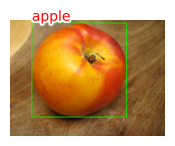

(768, 1024, 3)

In [98]:
food_df = pd.read_csv('google_images/df.csv')
image_ds = ImageDataset(food_df, IMAGE_FOLDER)
image, bboxes, classes, image_file = image_ds[20]
show(image, bbs=bboxes, texts=classes, sz=2, text_sz=10)
print(image.shape)

name 'torch' is not defined

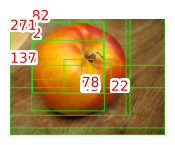

In [82]:
def extract_candidates(img):
  # img - (h,w,3)
  candidates = []
  img_lbl, regions = selectivesearch.selective_search(img, min_size=50,scale=150)
  image_area = np.prod(img.shape[:2])
  for r in regions:
    if r in candidates: continue
    if r['size'] < image_area * 0.05: continue
    if r['size'] > image_area * 1: continue
    candidates.append(list(r['rect']))
  return candidates
candidates = extract_candidates(image)

show(image, bbs=candidates, texts=[f'{i}' for i in range(len(candidates))], sz=2, text_sz=10)

In [99]:
def extract_iou(boxA, boxB, epsilon = 1e-5):
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])
  # Intersection area
  width = x2 - x1
  height = y2 - y1
  intersection_area = width * height
  boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  total_area = (boxA_area + boxB_area) - intersection_area
  iou = intersection_area / (total_area + epsilon)
  return iou


In [101]:
import warnings
warnings.filterwarnings('ignore')
FPATHS, GTBBS, CLSS ,DELTAS, ROIS, IOUS = [], [], [], [], [], []

# For each image on the ds
for ix, (image, bboxes, classes, image_file) in enumerate(image_ds):
	
	H, W, _ = image.shape
	clss, deltas, rois, ious = [], [], [], []
	# 1. Extract the candidates
	candidates = extract_candidates(image)
	# 1.1 Pass the candidates to xmin, ymin, xmax, ymax format
	candidates = np.array([[x,y,x+w,y+h] for (x,y,w,h) in candidates])
	# 2. Extract the IOUS for each candidate and the ground truth bbs the final shape is (len(candidates), len(ground_truth_bbs))
	ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bboxes]).T
	# 3. For each candidate
	for jx, candidate in enumerate(candidates):
		# 3.1 Extract the ious for the candidate
		candidate_ious = ious[jx]
		# 3.2 Extract the coordinates for the candidate
		cx, cy, cX, cY = candidate
		# 3.3 Extract the best iou
		best_iou_idx = np.argmax(candidate_ious)
		best_iou = candidate_ious[best_iou_idx]
		# 3.4 Extract the best iou coordinates
		best_iou_bb = _x, _y, _X, _Y = bboxes[best_iou_idx]
		# 3.5 If the best iou is > 0.3 then the candidate is a positive sample - if not it is background
		if best_iou > 0.3:
			clss.append(classes[best_iou_idx])
		else:
			clss.append('background')
		# 3.6 Extract the deltas for the candidate - divide by the image width and height
		delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
		roi = np.array([cx, cy, cX, cY]) / np.array([W, H, W, H])
		deltas.append(delta)
		rois.append(roi)
		
	# 4. Append image path
	FPATHS.append(image_file)
	# 4. append rois
	ROIS.append(rois)
	# 4. append deltas
	DELTAS.append(deltas)
	# 4. append ious
	IOUS.append(ious)
	# 4. append ground truth bbs
	GTBBS.append(bboxes)
	# 4. append classes
	CLSS.append(clss)
	if ix % 100 == 0:
		print(f"Parsed {ix}/{len(image_ds)} images")
 

Parsed 0/1965 images

Parsed 100/1965 images

Parsed 200/1965 images

Parsed 300/1965 images

Parsed 400/1965 images

Parsed 500/1965 images

Parsed 600/1965 images

Parsed 700/1965 images

Parsed 800/1965 images

Parsed 900/1965 images

Parsed 1000/1965 images

Parsed 1100/1965 images

Parsed 1200/1965 images

Parsed 1300/1965 images

Parsed 1400/1965 images

Parsed 1500/1965 images

Parsed 1600/1965 images

Parsed 1700/1965 images

Parsed 1800/1965 images

Parsed 1900/1965 images

In [102]:
# Save the data to a csv
df = pd.DataFrame(columns=['file_path', 'x', 'y','X','Y', 'dx', 'dy', 'dX', 'dY','class'])
for ix, (fpath, clss, deltas, rois) in enumerate(zip(FPATHS, CLSS, DELTAS, ROIS)):
	# If the clss is full of background then skip it
	if all([c == 'background' for c in clss]):
		continue
	# This will run for each image
	for jx, (cls, delta, roi) in enumerate(zip( clss, deltas, rois)):
		
		x, y, X, Y = roi
		dx, dy, dX, dY = delta
		# Create a row
		row = [fpath, x, y, X, Y, dx, dy, dX, dY, cls]
		df.loc[len(df)] = row
		

In [113]:
original_df = generate_df()
# Add the real label for each row on the df using the original df
df['label'] = df['file_path'].apply(lambda x: original_df[original_df['file_name'] == x.split('/')[-1]]['label'].values[0])

In [115]:
# Save the dataset
df.to_csv('datasets/ds_images.csv', index=False)


In [112]:
FPATHS = df['file_path'].unique()
# Extract clss from the df
CLSS = [df[df['file_path'] == fpath]['class'].values for fpath in FPATHS]
# Extract deltas from the df
DELTAS = [df[df['file_path'] == fpath][['dx','dy','dX','dY']].values for fpath in FPATHS]
# Extract rois from the df
ROIS = [df[df['file_path'] == fpath][['x','y','X','Y']].values for fpath in FPATHS]


1965

In [215]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [224]:
normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]) # why these numbers
def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)  # h, w, c - c, h, w
  img = normalize(img)
  return img.to(device).float()
def decode(_y):
  _, preds = _y.max(-1)
  return preds

class RCNNDataset(Dataset):
  def __init__(self, fpaths, rois, labels, deltas):
    self.fpaths = fpaths
    self.rois = rois
    self.labels = labels
    self.deltas = deltas
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    fpath = str(self.fpaths[ix])
    image_path = f'{IMAGE_FOLDER}/{fpath}'
    image = cv2.imread(image_path, 1)[...,::-1]
    H,W,_ = image.shape
    sh = np.array([W,H,W,H])
    rois = self.rois[ix]
    bbs = (np.array(rois)*sh).astype(np.uint16)
    labels = self.labels[ix]
    deltas = self.deltas[ix]
    crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
    return image, crops, bbs, labels, deltas, fpath

  def collate_fn(self, batch):
    input, rois, rixs, labels, deltas = [], [], [], [], []
    for ix in range(len(batch)):
      image,crops,image_bbs,image_labels,image_deltas,image_fpath = batch[ix]
      crops = [cv2.resize(crop, (244,244)) for crop in crops]
      crops = [preprocess_image(crop/255.)[None] for crop in crops]
      input.extend(crops)
      labels.extend([label2target[c] for c in image_labels])
      deltas.extend(image_deltas)
    input = torch.cat(input).to(device)
    labels = torch.Tensor(labels).long().to(device)
    deltas = torch.Tensor(deltas).float().to(device)
    return input, labels, deltas

In [225]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train],DELTAS[:n_train],)
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:],DELTAS[n_train:],)

In [226]:
from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)